<a href="https://colab.research.google.com/github/hugosdef/ufv_Visualizacion_de_datos/blob/main/Clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRÁCTICA 1**
Visualización de Datos.

Hugo Santos de Felipe

Se importan las librerias necesarias para realizar el ejercicio.

In [452]:
from google.colab import files
import pandas as pd
from IPython.display import display
import warnings
import plotly.express as px
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Con la siguiente línea de código se suprimirán las advertencias de obsolescencia (deprecation warnings) que se mostrarían en el código si no se utilizase. Estos warnings solo indican que se está utilizando una función que ha sido marcada como obsoleta y que se eliminará en futuras versiones.

In [453]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# CARGA DE LA BASE DE DATOS

In [454]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
dfVentas = pd.read_csv(filename, delimiter=',')
dfVentas.head(5)

Saving datos_ejercicio_ventas (1).csv to datos_ejercicio_ventas (1) (4).csv


,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


# ANÁLISIS DE LA BASE DE DATOS

## NANS Y NULLS

Se comprueba los NaNs y los nulls además del tipo de variable de cada atributo.

In [455]:
dfVentas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18666 entries, 0 to 18665
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTRY        18666 non-null  object 
 1   SUBBRAND       18666 non-null  object 
 2   YEAR           18666 non-null  int64  
 3   MONTH          18666 non-null  int64  
 4   SCENARIO       18666 non-null  object 
 5   FORECAST       17766 non-null  object 
 6   FORECAST_YEAR  17766 non-null  float64
 7   AMOUNT         18666 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.1+ MB


Hay Nulls en la bbdd, en concreto, 900 pertenecientes al atributo FORECAST y 900 a FORECAST_YEAR, se procede a analizar los NaNs pues estos no siempre se consideran Nulls.

In [456]:
dfVentas.isna().sum()

,0
COUNTRY,0
SUBBRAND,0
YEAR,0
MONTH,0
SCENARIO,0
FORECAST,900
FORECAST_YEAR,900
AMOUNT,0


## EXPLICACIÓN DE VARIABLES

*  **COUNTRY y SUBBRAND**: Indican el país y la sub-marca del producto para el cual se registran las ventas.

*  **YEAR y MONTH:** Indican el año y el mes del registro:

  Si el registro es un valor "actual" (observado), YEAR y MONTH son el año y mes en que se obtuvieron los datos.

  Si el registro es una predicción ("AI_forecast"), YEAR y MONTH indican el período al cual se aplica esa predicción.

*  **SCENARIO**: Determina si el registro es una predicción (AI_forecast) o un valor "actual" (realmente observado).

*  **FORECAST**: Mes en el que se generó la predicción. La fórmula para calcular el mes a partir del registro de FORECAST es AI_PXXF = XX - 01, siendo, por ejemplo, P02F = 02 - 01 = 01 que es el mes 1, por lo tanto AI_P02F es enero.
AI_PF corresponde a diciembre.
Solo aplica cuando el valor es una proyección (AI_forecast).

*  **FORECAST_YEAR:** Año en que se generó la predicción. Solo aplica cuando el valor es una proyección (AI_forecast).

*  **AMOUNT:** Indica la cantidad (de ventas, ingresos, u otra métrica) para el registro. Dependiendo de SCENARIO:

    Si el SCENARIO es "actual", AMOUNT es el valor observado en el año y mes indicados.

    Si el SCENARIO es "AI_forecast", AMOUNT es el valor estimado por la IA para el período especificado.

Una vez explicadas las variables, se procede a comprobar que todos los NaNs encontrados en FORECAST Y FORECAST_YEAR equivalen a cuando el valor de SCENARIO es actual.

In [457]:
dfVentas[dfVentas['SCENARIO'] == 'actual'].isna().sum()

,0
COUNTRY,0
SUBBRAND,0
YEAR,0
MONTH,0
SCENARIO,0
FORECAST,900
FORECAST_YEAR,900
AMOUNT,0


Efectivamente, es correcto que esos valores de los atributos FORECAST Y FORECAST_YEAR sean NaNs ya que corresponden a registros que no son predicciones si no ventas reales.

## CAMBIO DE FORECAST_YEAR A VARIABLE DE TIPO ENTERO

Se procede a cambiar el tipo de variable ya que aunque no parezca un problema a la hora de manejar el dato, los años son siempre números enteros.

In [458]:
dfVentas['FORECAST_YEAR'] = pd.to_numeric(dfVentas['FORECAST_YEAR'], errors='coerce').astype('Int64')
print(dfVentas['FORECAST_YEAR'].dtype)

Int64


## REGISTROS DUPLICADOS

Se procede a comprobar si hay registros exactamente idénticos en la bbdd, en caso afirmativo se procedería a la eliminación de los duplicados.

In [459]:
duplicados = dfVentas[dfVentas.duplicated()]
print(len(duplicados))

663


In [460]:
print(duplicados)

             COUNTRY       SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
349    Great Britain    Lipton (L3)  2024      9  AI_forecast  AI_P11F   
455    Great Britain    Lipton (L3)  2024      6  AI_forecast  AI_P03F   
540    Great Britain  7up Free (L3)  2024      2  AI_forecast    AI_PF   
652    Great Britain    Lipton (L3)  2024      1  AI_forecast  AI_P05F   
789    Great Britain    Lipton (L3)  2024     11  AI_forecast  AI_P11F   
...              ...            ...   ...    ...          ...      ...   
18590        Hungary       7up (L3)  2025      1  AI_forecast  AI_P12F   
18606  Great Britain  7up Free (L3)  2024      8  AI_forecast  AI_P03F   
18631  Great Britain       7up (L3)  2024     10  AI_forecast  AI_P11F   
18649  Great Britain    Lipton (L3)  2024      5  AI_forecast  AI_P11F   
18650  Great Britain    Lipton (L3)  2024      5  AI_forecast  AI_P09F   

       FORECAST_YEAR        AMOUNT  
349             2023  7.367201e+05  
455             2023  8.156165e+05  


## ELIMINAMOS REGISTROS DUPLICADOS

Al haber 663 registros duplicados, se procede a la eliminación de los mismos.

In [461]:
dfVentas = dfVentas.drop_duplicates()

## COMPROBACIÓN AMOUNTS NEGATIVOS

Dado que no se puede haber ventas negativas, nos quedamos solo con los AMOUNTs positivos o iguales a cero, ya que se debe entender que tu puedes o no vender algo pero considero que los AMOUNTs negativos son errores, aunque también entiendo que se pueda interpretar como que se han comprado X productos y no se han vendido ninguno por lo que son pérdidas.

In [462]:
dfVentas = dfVentas[dfVentas['AMOUNT'] >= 0]

## DISTRIBUCIÓN DE ACTUAL Y DE FORECAST

Se procede a comprobar cuantos registros de la base de datos corresponden a predicciones y cuantos son ventas reales.

In [463]:
fig = px.pie(dfVentas['SCENARIO'].value_counts().reset_index(name='COUNT'), values='COUNT', names='SCENARIO', hole=0.4,
             title='Distribución de actual y AI_forecast')
fig.show()

## NÚMERO DE PAÍSES

In [464]:
paises = dfVentas['COUNTRY'].unique()
print(paises)

['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


### DISTRIBUCIÓN DE LOS PAÍSES

In [465]:
fig = px.pie(dfVentas['COUNTRY'].value_counts().reset_index(name='COUNT').sort_values(by='COUNT', ascending=False), values='COUNT', names='COUNTRY', hole=0.4, title='Distribución de Países', category_orders={"COUNTRY": dfVentas['COUNTRY'].value_counts().index.tolist()})
fig.show()


El país con mas registros es Gran Bretaña y el que menos es Italia, importante destacar que esto no tiene nada que ver con la cantidad de dinero vendido en cada país, puede coincidir, y tener alguna relación, pero veremos como España ha recaudado menos en ventas que Italia.

## NÚMERO DE PRODUCTOS


In [466]:
productos = dfVentas['SUBBRAND'].unique()
print(productos)


['Lipton (L3)' 'Pepsi Max (L3)' '7up (L3)' 'Pepsi Regular (L3)'
 'Mountain Dew (L3)' '7up Free (L3)']


### DISTRIBUCIÓN DE PRODUCTOS

In [467]:
fig = px.pie(dfVentas['SUBBRAND'].value_counts().reset_index(name='COUNT').sort_values(by='COUNT', ascending=False), values='COUNT', names='SUBBRAND', hole=0.4, title='Distribución de Productos sin tener en cuenta países.', category_orders={"SUBBRAND": dfVentas['SUBBRAND'].value_counts().index.tolist()})
fig.show()

Lo mismo, el producto con más registros es Pepsi Max (L3).

## FORECASTS DISTINTOS

In [468]:
dfVentas['FORECAST'].unique()

array(['AI_P02F', 'AI_P10F', 'AI_P09F', 'AI_P03F', 'AI_PF', 'AI_P11F',
       'AI_P06F', 'AI_P05F', 'AI_P07F', 'AI_P12F', 'AI_P08F', 'AI_P04F',
       nan], dtype=object)

## HORIZONTE DE PREVISIÓN

A continuación, se procede a calcular el horizonte de previsión, que es el período de tiempo en el futuro para el cual se realizan predicciones o proyecciones en un modelo de pronóstico.

Se calcula el primer ejemplo de horizonte de previsión para las predicciones hechas en el mes 7 del año 2023 en la marca Pepsi Regular y en Dinamarca.

In [469]:
horizonte_prediccion = dfVentas[(dfVentas['FORECAST'] == 'AI_P08F') & (dfVentas['FORECAST_YEAR'] == 2023) & (dfVentas['COUNTRY'] == 'Denmark') & (dfVentas['SUBBRAND'] == 'Pepsi Regular (L3)') & (dfVentas['SCENARIO'] == 'AI_forecast')].sort_values(by=['YEAR', 'MONTH'])
horizonte_prediccion.head(26)

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
3811,Denmark,Pepsi Regular (L3),2023,8,AI_forecast,AI_P08F,2023,251340.631789
17748,Denmark,Pepsi Regular (L3),2023,8,AI_forecast,AI_P08F,2023,300056.654872
13732,Denmark,Pepsi Regular (L3),2023,9,AI_forecast,AI_P08F,2023,223857.384404
14990,Denmark,Pepsi Regular (L3),2023,9,AI_forecast,AI_P08F,2023,263495.455502
8145,Denmark,Pepsi Regular (L3),2023,10,AI_forecast,AI_P08F,2023,196574.598740
10444,Denmark,Pepsi Regular (L3),2023,10,AI_forecast,AI_P08F,2023,201261.846779
1813,Denmark,Pepsi Regular (L3),2023,11,AI_forecast,AI_P08F,2023,219587.320243
9806,Denmark,Pepsi Regular (L3),2023,11,AI_forecast,AI_P08F,2023,219438.373663
5690,Denmark,Pepsi Regular (L3),2023,12,AI_forecast,AI_P08F,2023,271617.496365
15594,Denmark,Pepsi Regular (L3),2023,12,AI_forecast,AI_P08F,2023,265682.579106


In [470]:
print(len(horizonte_prediccion))

36


Aunque haya 36 registros en total para ciertas características, el horizonte de previsión se define por los períodos únicos (combinaciones de YEAR y MONTH) para los cuales se han hecho predicciones. Si hay dos predicciones por mes, no significa que el horizonte sea de 36 meses, sino que se necesita contar los períodos únicos.

Se calcula a continuación todos los horizontes sin tener en cuenta que sean únicos.

In [471]:
conteoDUPLICTS = dfVentas.groupby(['COUNTRY', 'SUBBRAND', 'FORECAST', 'FORECAST_YEAR']).size().value_counts().reset_index()
print(conteoDUPLICTS)

    index  count
0      18    345
1      36    103
2      54     34
3      72     30
4      42     27
5      60     11
6     180      5
7      90      2
8      59      2
9      58      2
10     27      1
11     25      1
12     29      1


Una vez tenemos todos, pasamos a eliminar los registros duplicados del subset de variables 'COUNTRY', 'SUBBRAND', 'FORECAST', 'FORECAST_YEAR', 'YEAR', 'MONTH' y luego se agrupa por país, marca, forecast y año de forecast.
De esta manera, todos los horizontes de previsión deberían ser de 18.

In [472]:
df_unicos = dfVentas.drop_duplicates(subset=['COUNTRY', 'SUBBRAND', 'FORECAST', 'FORECAST_YEAR', 'YEAR', 'MONTH'])
conteo_unicos = df_unicos.groupby(['COUNTRY', 'SUBBRAND', 'FORECAST', 'FORECAST_YEAR']).size().value_counts().reset_index(name='NUMERO_REGISTROS_UNICOS')
print(conteo_unicos)

   index  NUMERO_REGISTROS_UNICOS
0     18                      564


## PERIODO

Se crea una nueva variable llamada PERIODO que es la concatenación de YEAR y MONTH para facilitar el trabajo con esta variables

In [473]:
dfVentas.loc[:, 'PERIODO'] = pd.to_datetime(dfVentas['YEAR'].astype(str) + '-' + dfVentas['MONTH'].astype(str).str.zfill(2))

## PERIODO 2

Se crea otra variable que sea la concatenación de forecast y forecast_year.

In [474]:
forecast_a_mes = {
     'AI_P02F': 2, 'AI_P03F': 3, 'AI_P04F': 4,
    'AI_P05F': 5, 'AI_P06F': 6, 'AI_P07F': 7, 'AI_P08F': 8,
    'AI_P09F': 9, 'AI_P10F': 10, 'AI_P11F': 11, 'AI_P12F': 12,
    'AI_PF': 1
}

Resaltar que considero que AI_P02F lo considero febrero y AI_PF enero ya que aunque desde un principio se consideró que es un mes menos del número, a la hora de realizarlo con el orden establecido desde el principio, salen distancias negativas entre las variables de PERIODO y PERIODO 2

In [475]:
dfVentas['MESPRED'] = dfVentas['FORECAST'].map(forecast_a_mes)

In [476]:
dfVentas['MESPRED'] = pd.to_numeric(dfVentas['MESPRED'], errors='coerce').astype('Int64')

In [477]:
dfVentas['FECHASEHIZOPRED'] = pd.to_datetime(
    dfVentas['FORECAST_YEAR'].astype('Int64', errors='ignore').astype(str) + '-' +
    dfVentas['MESPRED'].fillna(1).astype(int).astype(str).str.zfill(2),
    errors='coerce'
)

## DISTANCIA ENTRE PREDICCIÓN Y FECHA DE PREDICCIÓN

In [478]:
dfVentas.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023,754356.237194,2023-12-01,2,2023-02-01
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023,560030.558029,2023-12-01,10,2023-10-01
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,2023-12-01,9,2023-09-01
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023,363224.511516,2024-12-01,10,2023-10-01
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023,396176.120491,2023-09-01,3,2023-03-01


Calculo la distancia entre las dos variables de PERIODO y FECHASEHIZOPRED para en un futuro hacer un estudio de las predicciones.

In [503]:
dfVentas['DISTANCIA_MESES'] = (
    (dfVentas['PERIODO'].dt.year - dfVentas['FECHASEHIZOPRED'].dt.year) * 12 +
    (dfVentas['PERIODO'].dt.month - dfVentas['FECHASEHIZOPRED'].dt.month)
)

In [480]:
dfVentas.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023,754356.237194,2023-12-01,2,2023-02-01,10.0
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023,560030.558029,2023-12-01,10,2023-10-01,2.0
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,2023-12-01,9,2023-09-01,3.0
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023,363224.511516,2024-12-01,10,2023-10-01,14.0
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023,396176.120491,2023-09-01,3,2023-03-01,6.0


In [481]:
distancias = dfVentas['DISTANCIA_MESES'].unique()
print(distancias)

[10.  2.  3. 14.  6. 17. 11.  7.  1.  5. 13. 16.  9. 15. 12.  4.  0.  8.
 nan]


## HISTÓRICO DE ACTUALS / FORECASTS

Este gráfico muestra una información similar a la Distribución de los Productos previamente mostrada por un gráfico, pero divide la distribución de cada producto en actuals y forecasts.

In [482]:
fig = px.bar(dfVentas.groupby(['SCENARIO', 'SUBBRAND']).size().reset_index(name='COUNT'), x='SUBBRAND', y='COUNT', color='SCENARIO',
             title='Histórico de Registros por Sub-marca y Tipo de Escenario',
             labels={'COUNT': 'Número de Registros', 'SUBBRAND': 'Sub-marca', 'SCENARIO': 'Tipo de Escenario'})

fig.show()

Mountain Dew es el producto que menos registro de actuals esto es porque se vende en menos países que Pepsi Regular.

# NUEVO DATASET SOLO DE VENTAS

Para realizar la primera parte del ejercicio de manera adecuada, creamos un nuevo dataset solo de ventas reales, es decir, cuando el SCENARIO es actual.

In [483]:
df_ventas_actual = dfVentas.copy()
df_ventas_actual = df_ventas_actual[dfVentas['SCENARIO'] == 'actual']
df_ventas_actual.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,<NA>,1.885949e+05,2023-10-01,<NA>,NaT,NaN
278,Portugal,7up (L3),2023,3,actual,NaN,<NA>,2.934971e+05,2023-03-01,<NA>,NaT,NaN
279,Portugal,7up (L3),2023,10,actual,NaN,<NA>,3.484466e+05,2023-10-01,<NA>,NaT,NaN
280,Great Britain,7up Free (L3),2023,10,actual,NaN,<NA>,1.172553e+06,2023-10-01,<NA>,NaT,NaN
281,Norway,Pepsi Regular (L3),2023,10,actual,NaN,<NA>,3.784859e+04,2023-10-01,<NA>,NaT,NaN


In [484]:
len(df_ventas_actual)

890

# DISTRIBUCIÓN DE VENTAS POR PAÍS

In [485]:
ventas_pais = df_ventas_actual.groupby(['COUNTRY'])['AMOUNT'].sum().reset_index(name='TOTAL_VENTAS')
print(ventas_pais)

         COUNTRY  TOTAL_VENTAS
0          Czech  3.535164e+07
1        Denmark  5.659668e+07
2  Great Britain  3.347786e+08
3        Hungary  4.157947e+07
4          Italy  4.345404e+07
5    Netherlands  6.395943e+07
6         Norway  5.143697e+07
7       Portugal  3.488807e+07
8          Spain  8.131266e+06


Se puede comprobar que es España el país con menos ventas y Gran Bretaña el país con más ventas.

In [486]:
ventas_pais['COUNTRY'] = ventas_pais['COUNTRY'].replace({
    'Czech': 'Czech Republic',
})

fig = px.choropleth(ventas_pais, locations="COUNTRY", locationmode="country names", color="TOTAL_VENTAS",
                    title="Distribución de Ventas Realizadas por País",
                    labels={'Ventas Totales'})

fig.update_geos(scope="europe")

fig.show()




Como Gran Bretaña tiene un volumen de ventas mucho mayor en comparación con los demás, en un gráfico coroplético (o cualquier visualización de distribución) los valores de los otros países se ven con colores mucho más oscuros o uniformes, lo que dificulta la interpretación de las diferencias entre esos países.

Una solución podría ser aplicar una transformación logarítmica pero podría suponer un impedimento si el cliente no entiende que la escala no es lineal.

# DISTRIBUCIÓN DE LAS VENTAS REALIZADAS POR MES Y AÑO

In [487]:
ventas_periodo = df_ventas_actual.groupby('PERIODO')['AMOUNT'].sum().reset_index(name='TOTAL_VENTAS')
print(ventas_periodo)

      PERIODO  TOTAL_VENTAS
0  2023-01-01  2.808880e+07
1  2023-02-01  2.610437e+07
2  2023-03-01  3.593163e+07
3  2023-04-01  3.085725e+07
4  2023-05-01  3.690245e+07
5  2023-06-01  3.759999e+07
6  2023-07-01  3.403860e+07
7  2023-08-01  3.817477e+07
8  2023-09-01  3.216776e+07
9  2023-10-01  3.144918e+07
10 2023-11-01  3.291774e+07
11 2023-12-01  3.483175e+07
12 2024-01-01  2.689110e+07
13 2024-02-01  2.989003e+07
14 2024-03-01  3.449766e+07
15 2024-04-01  3.369920e+07
16 2024-05-01  3.677264e+07
17 2024-06-01  3.508763e+07
18 2024-07-01  3.571656e+07
19 2024-08-01  3.855704e+07


In [488]:
fig = px.line(ventas_periodo, x='PERIODO', y='TOTAL_VENTAS', title='Distribución de Ventas Realizadas por Mes y Año', labels={'NUM_VENTAS': 'Número de Ventas', 'PERIODO': 'Fecha'})
fig.show()

Este gráfico muestra la distribución de ventas realizadas por mes y año y refleja el comportamiento general de las ventas en todos los países, pero es importante destacar que este tipo de gráfico no es representativo de las tendencias o características de un solo país y se puede comprobar que en los meses de Enero se ha consumido menos en todos los países, lo que podría estar relacionado con la finalización de la Navidad.

# DISTRIBUCIÓN DE LAS VENTAS POR MARCA

In [489]:
ventas_marca_periodo = df_ventas_actual.groupby(['SUBBRAND', 'PERIODO'])['AMOUNT'].sum().reset_index(name='TOTAL_VENTAS')

fig = px.line(ventas_marca_periodo, x='PERIODO', y='TOTAL_VENTAS', color='SUBBRAND',
              title='Distribución de Ventas Realizadas por Marca a lo Largo del Tiempo',
              labels={'NUM_VENTAS': 'Número de Ventas', 'PERIODO': 'Fecha', 'SUBBRAND': 'Marca'})
fig.show()


Podemos ver que todas siguen más o menos la misma distribución, aunque cada una con su cantidad de ventas por mes particular. La marca más vendida es Pepsi y la que menos Mountain Dew.

# TENDENCIA Y ESTACIONALIDAD DE TODAS LAS VENTAS DEL PAÍS CON MENOS VENTAS

In [490]:
ventas_pais = df_ventas_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index(name='TOTAL_VENTAS')
ventas_pais = ventas_pais.sort_values(by=['TOTAL_VENTAS'])
ventas_pais.head(1)

,COUNTRY,TOTAL_VENTAS
8,Spain,8.131266e+06


Podemos comprobar que efectivamente, aunque ya lo sabíamos antes es España el país con menos ventas.

In [491]:
dfVentas_Espana = df_ventas_actual[df_ventas_actual['COUNTRY'] == 'Spain']
dfVentas_Espana.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
296,Spain,7up Free (L3),2023,10,actual,NaN,<NA>,83196.895876,2023-10-01,<NA>,NaT,NaN
414,Spain,7up Free (L3),2024,1,actual,NaN,<NA>,60318.994231,2024-01-01,<NA>,NaT,NaN
728,Spain,7up Free (L3),2024,2,actual,NaN,<NA>,59482.850585,2024-02-01,<NA>,NaT,NaN
729,Spain,Lipton (L3),2024,2,actual,NaN,<NA>,8003.513133,2024-02-01,<NA>,NaT,NaN
835,Spain,7up (L3),2024,4,actual,NaN,<NA>,74882.992962,2024-04-01,<NA>,NaT,NaN


In [492]:


ventas_periodo = dfVentas_Espana.groupby('PERIODO')['AMOUNT'].sum().reset_index()

fig = px.line(ventas_periodo, x='PERIODO', y='AMOUNT',
              title='Tendencia y Estacionalidad de Ventas en España',
              labels={'AMOUNT': 'Total Ventas', 'PERIODO': 'Fecha', 'COUNTRY': 'Spain'})

ventas_periodo['TENDENCIA'] = ventas_periodo['AMOUNT'].rolling(window=3, center=True).mean()

fig.add_scatter(x=ventas_periodo['PERIODO'], y=ventas_periodo['TENDENCIA'], mode='lines', name='Tendencia')
fig.show()

Estacionalidad: La estacionalidad se refiere a patrones recurrentes que ocurren en un intervalo de tiempo específico, como las ventas que tienden a aumentar en ciertos meses del año. Los picos en las ventas en los meses de julio indica que hay un período de alta demanda en verano. Por lo que la estacionalidad diría que es anual.

Tendencia: Aunque la línea de tendencia roja suaviza las fluctuaciones para mostrar la dirección general de las ventas, en este caso no se observa una tendencia clara (ascendente o descendente) a lo largo de los meses.

# TENDENCIA Y ESTACIONALIDAD DE LA MARCA CON MÁS VENTAS

Se filtra la base de de datos agrupándola por el producto y la suma de las ventas y luego se ordena de mayor a menor para ver la marca con más ventas.

In [493]:
ventas_marca = df_ventas_actual.groupby('SUBBRAND')['AMOUNT'].sum().reset_index(name='TOTAL_VENTAS_MARCA')
ventas_marca = ventas_marca.sort_values(by=['TOTAL_VENTAS_MARCA'], ascending=False)
ventas_marca.head(1)

,SUBBRAND,TOTAL_VENTAS_MARCA
4,Pepsi Max (L3),3.966987e+08


In [494]:
dfVentas_mayor_marca = df_ventas_actual[df_ventas_actual['SUBBRAND'] == 'Pepsi Max (L3)']
dfVentas_mayor_marca.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,<NA>,1.885949e+05,2023-10-01,<NA>,NaT,NaN
724,Denmark,Pepsi Max (L3),2024,2,actual,NaN,<NA>,2.557571e+06,2024-02-01,<NA>,NaT,NaN
727,Italy,Pepsi Max (L3),2024,2,actual,NaN,<NA>,1.928897e+05,2024-02-01,<NA>,NaT,NaN
740,Norway,Pepsi Max (L3),2024,2,actual,NaN,<NA>,2.119033e+06,2024-02-01,<NA>,NaT,NaN
836,Denmark,Pepsi Max (L3),2024,4,actual,NaN,<NA>,2.090877e+06,2024-04-01,<NA>,NaT,NaN


In [495]:


ventas_marca_periodo = dfVentas_mayor_marca.groupby(['SUBBRAND', 'PERIODO'])['AMOUNT'].sum().reset_index()
ventas_marca_periodo['TENDENCIA'] = ventas_marca_periodo['AMOUNT'].rolling(window=3, center=True).mean()

fig = px.line(ventas_marca_periodo, x='PERIODO', y='AMOUNT', color='SUBBRAND',
              title='Tendencia y Estacionalidad de Pepsi Max (L3)',
              labels={'AMOUNT': 'Total Ventas', 'PERIODO': 'Fecha', 'SUBBRAND': 'Marca'})

fig.add_scatter(x=ventas_marca_periodo['PERIODO'], y=ventas_marca_periodo['TENDENCIA'], mode='lines', name='Tendencia', line=dict(color='red'))

fig.show()

Se puede contemplar una tendencia ligeramente ascendente y una estacionalidad quetrimestral.

Como no se observa tan claro como la anterior, haré un decompose para sacar buenas conclusiones.

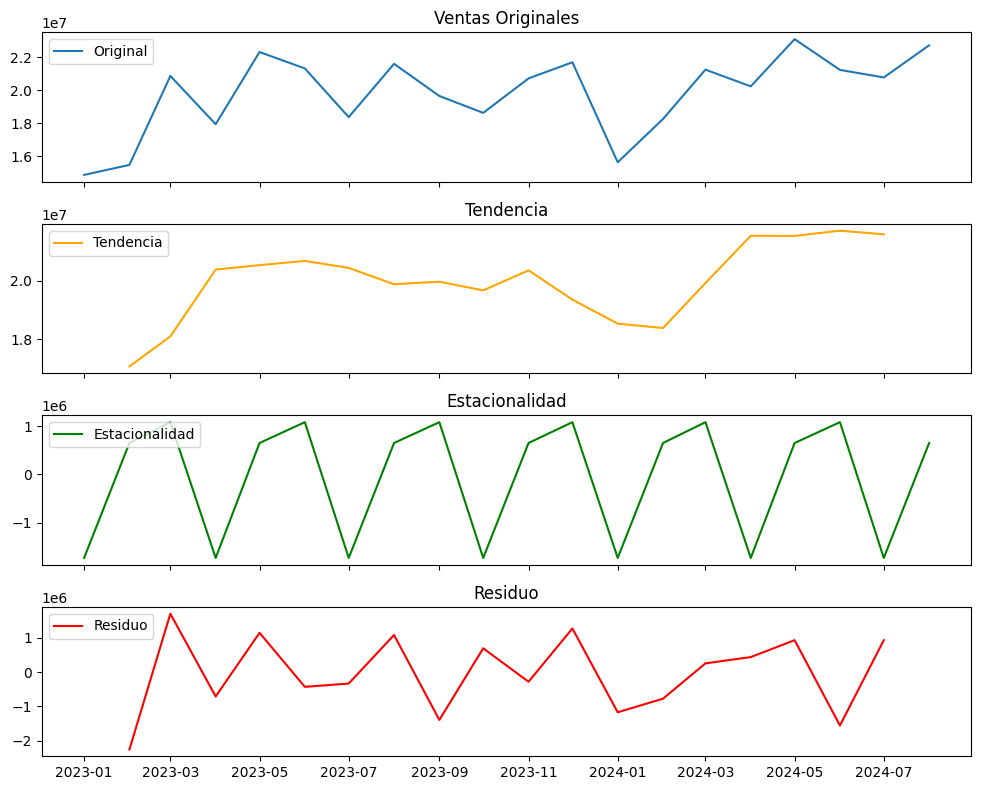

In [496]:

ventas_marca_periodo['PERIODO'] = pd.to_datetime(ventas_marca_periodo['PERIODO'])
ventas_marca_periodo.set_index('PERIODO', inplace=True)


result = seasonal_decompose(ventas_marca_periodo['AMOUNT'], model='additive', period=3)


fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(result.observed, label='Original')
axes[0].legend(loc='upper left')
axes[0].set_title('Ventas Originales')

axes[1].plot(result.trend, label='Tendencia', color='orange')
axes[1].legend(loc='upper left')
axes[1].set_title('Tendencia')

axes[2].plot(result.seasonal, label='Estacionalidad', color='green')
axes[2].legend(loc='upper left')
axes[2].set_title('Estacionalidad')

axes[3].plot(result.resid, label='Residuo', color='red')
axes[3].legend(loc='upper left')
axes[3].set_title('Residuo')

plt.tight_layout()
plt.show()


Podemos observar una tendencia ligeramente ascendente y una estocionalidad clara timestral.

# PREDICCIONES HECHAS EN ESPAÑA Y COMO DE BUENAS SON

## DATASET SOLO DE ESPAÑA

In [497]:
df_ventas_espana = dfVentas.copy()
df_ventas_espana = df_ventas_espana[(df_ventas_espana['COUNTRY'] == 'Spain')]
df_ventas_espana.head()


,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,2023-12-01,9,2023-09-01,3.0
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023,134268.151080,2023-12-01,5,2023-05-01,7.0
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023,9702.217953,2025-03-01,11,2023-11-01,16.0
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023,70144.329753,2024-01-01,4,2023-04-01,9.0
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023,38882.921227,2024-04-01,2,2023-02-01,14.0


Comprobamos que el numero de registros del datases df_ventas_espana sea 2152

In [498]:
print(len(df_ventas_espana))

2152


## RESOLUCIÓN

Planteamos un gráfico de los forecast frente a los actuals por producto.

In [499]:
fig = px.scatter(df_ventas_espana, x='PERIODO', y='AMOUNT', color='SCENARIO',
                 facet_col='SUBBRAND', facet_col_wrap=2,
                 title='Comparación de Ventas Actual y Forecast por Sub-marca en España',
                 labels={'AMOUNT': 'Ventas', 'PERIODO': 'Fecha', 'Tipo': 'Tipo de Valor'})

fig.update_layout(
    legend_title_text='Tipo de Ventas',
    title_x=0.5,
    margin=dict(t=60, b=40, l=40, r=40),
    height=1200
)

fig.update_xaxes(matches=None, showticklabels=True)

fig.show()

Se repite el mismo gráfico pero en vez de graficar todas las predicciones para cada periodo se grafica la predicción más cercana a la fecha del actual. Esto se hará mediante el uso de la variable DISTANCIA_MESES previamente calculada. En caso de que haya varias predicciones en la misma fecha y sean las más cercanas, se hará la media para calcular la definitiva.

In [500]:
df_ventas_espana.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,PERIODO,MESPRED,FECHASEHIZOPRED,DISTANCIA_MESES
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,2023-12-01,9,2023-09-01,3.0
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023,134268.151080,2023-12-01,5,2023-05-01,7.0
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023,9702.217953,2025-03-01,11,2023-11-01,16.0
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023,70144.329753,2024-01-01,4,2023-04-01,9.0
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023,38882.921227,2024-04-01,2,2023-02-01,14.0


In [501]:

min_distances = (
    df_ventas_espana[df_ventas_espana['SCENARIO'] == 'AI_forecast']
    .groupby(['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH'])['DISTANCIA_MESES']
    .min()
    .reset_index()
    .rename(columns={'DISTANCIA_MESES': 'MIN_DISTANCIA'})
)


closest_forecast = pd.merge(
    df_ventas_espana[df_ventas_espana['SCENARIO'] == 'AI_forecast'],
    min_distances,
    on=['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH']
)


closest_forecast = (
    closest_forecast[closest_forecast['DISTANCIA_MESES'] == closest_forecast['MIN_DISTANCIA']]
    .groupby(['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH'])
    .agg({'AMOUNT': 'mean'})  # Calcular la media si hay varios
    .reset_index()
    .rename(columns={'AMOUNT': 'CLOSEST_FORECAST'})
)


df_ventas_espana = pd.merge(
    df_ventas_espana,
    closest_forecast,
    on=['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH'],
    how='left'
)


df_ventas_espana['VALOR_PLOT'] = df_ventas_espana.apply(
    lambda row: row['CLOSEST_FORECAST'] if row['SCENARIO'] == 'AI_forecast' else row['AMOUNT'],
    axis=1
)



fig = px.scatter(
    df_ventas_espana,
    x='PERIODO',
    y='VALOR_PLOT',
    color='SCENARIO',
    facet_col='SUBBRAND',
    facet_col_wrap=2,
    title='Comparación de Ventas Actual y Forecast (Más Cercano por Meses) por Sub-marca en España',
    labels={'VALOR_PLOT': 'Ventas', 'PERIODO': 'Fecha', 'SCENARIO': 'Tipo de Valor'}
)

fig.update_layout(
    legend_title_text='Tipo de Ventas',
    title_x=0.5,
    margin=dict(t=60, b=40, l=40, r=40),
    height=1200
)

fig.update_xaxes(matches=None, showticklabels=True)

fig.show()


Una vez tenemos el gráfico correcto, se pueden contemplar que las predicicones parecen buenas pero para asegurarnos se calcula el mae y el mape de cada producto.


El MAE es la media del valor absoluto de los errores entre las predicciones y los valores reales. Es una medida de precisión que indica, en promedio, cuánto difieren las predicciones de los valores reales sin tener en cuenta la dirección del error (positiva o negativa).

El MAPE es la media del error absoluto en porcentaje, lo que permite interpretar el error en relación con el tamaño de los valores reales. Es útil para entender el error en términos relativos.

In [502]:

comparison_df = df_ventas_espana[
    (df_ventas_espana['SCENARIO'] == 'actual') & (df_ventas_espana['CLOSEST_FORECAST'].notna())
]


resultados_precision = []

for subbrand in comparison_df['SUBBRAND'].unique():

    datos_subbrand = comparison_df[comparison_df['SUBBRAND'] == subbrand]


    actual = datos_subbrand['AMOUNT']
    forecast_closest = datos_subbrand['CLOSEST_FORECAST']


    mae = abs(actual - forecast_closest).mean()
    mape = (abs((actual - forecast_closest) / actual) * 100).mean()

    resultados_precision.append({'SUBBRAND': subbrand, 'MAE': mae, 'MAPE': mape})


df_resultados_precision = pd.DataFrame(resultados_precision)

print(df_resultados_precision)


             SUBBRAND           MAE       MAPE
0       7up Free (L3)   7256.736177  10.450042
1         Lipton (L3)   1383.237510  13.537579
2            7up (L3)  13985.385707  16.012876
3  Pepsi Regular (L3)  17473.915391  13.992057
4      Pepsi Max (L3)  11577.363431  10.608117


Observaciones a destacar:


1.   7up tiene el MAPE más alto lo que significa que sus predicciones son menos precisas que las de otras marcas como  7up Free.
2.   Aunque Pepsi Regular tenga el MAE más alto, el MAPE de 14% indica que el error es razonable y el MAE es alto debido a que la cantidad de ventas es muy grande.
3. Pepsi Max y 7up Free tienen MAPE bajos, de 10.60% y 10.45%, nos indica que las predicciones son relativamente precisas.

